In [161]:
import bio_embeddings
from bio_embeddings.embed import ESM1bEmbedder
from tdc.multi_pred import GDA
from tdc import Evaluator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob2
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torchmetrics
import spacy
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
import gensim.downloader as api
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
data = GDA(name = 'DisGeNET')
split = data.get_split()
traindf = pd.DataFrame(split['train'])
valdf = pd.DataFrame(split['valid'])
testdf = pd.DataFrame(split['test'])
print('Training samples: ',len(traindf))
print('Validation samples: ',len(valdf))
print('Testing samples: ',len(testdf))

Found local copy...
Loading...
Done!


Training samples:  36733
Validation samples:  5248
Testing samples:  10495


<!-- ## Doc2Vec embeddings -->

<!-- In project_data_exploration.ipynb, I explored using Doc2Vec embeddings for disease descriptions which trained relatively fast.

For amino acid sequences, I earlier decided to use one-hot encoding, but given the lengthy sequences in this data, I've shifted to using ML embeddings for genes. I started exploring ESM transformer model for transfer learning but the pretrained model is limited to 1026 max sequence length. I want to find an appropriate pretrained model for long amino acid sequences, or utilize the existing ones to somehow ingest the whole sequence (in parts) but until then, I've decided to use Doc2Vec embeddings for genes.

The cells below tokenize and train Doc2Vec model for gene sequences

This is what I have so far. Last I checked the disease description embeddings were reasonable clustered together in PCA space for same disease IDs using doc2vec, but I don't have a way yet to benchmark the gene embeddings. What I'll do instead is benchmark ML gene embeddings against one-hot encodings.

I'll start training and testing this CNN model above and play around with the parameters, compare performance with different encodings, maybe also try transformer encodings. If I see reasonable results and if there is more time, I'll explore RNN architecture or a combination of RNN-CNN. -->

In [3]:
traindf

,Gene_ID,Gene,Disease_ID,Disease,Y
0,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0019209,Hepatomegaly: Abnormal enlargement of the liver.,0.30
1,1,MSMLVVFLLLWGVTWGPVTEAAIFYETQPSLWAESESLLKPLANVT...,C0036341,Schizophrenia: Schizophrenia is highly heritab...,0.30
2,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0002395,Alzheimer's Disease: Alzheimer disease is the ...,0.50
3,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0011265,Presenile dementia: The presence of dementia i...,0.30
4,2,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...,C0019202,Hepatolenticular Degeneration: Wilson disease ...,0.30
...,...,...,...,...,...
36728,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C0010051,Coronary Aneurysm: Abnormal balloon- or sac-li...,0.30
36729,100507436,MGLGPVFLLLAGIFPFAPPGAAAEPHSLRYNLTVLSWDGSVQSGFL...,C0029172,Oral Submucous Fibrosis: Irreversible FIBROSIS...,0.31
36730,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C0087031,Juvenile-Onset Still Disease: An inflammatory ...,0.30
36731,100820829,MLRSTSTVTLLSGGAARTPGAPSRRANVCRLRLTVPPESPVPEQCE...,C3495559,Juvenile arthritis: Juvenile arthritis (JUVAR)...,0.30


## Defining a class to process load dataset

In [230]:
class GDPair(torch.utils.data.Dataset):
    def __init__(self, data, datatype='train', embed='esm', load_from_save=False, mode='cont'):
        '''
        Torch dataset class to load GDA data
        Args:
            data (pd.DataFrame): Dataframe constructed from TDC split output
            datatype (str): train, val or test
            embed (str): Embedding method for amino acid sequence (doc2vec or esm)
            load_from_save (bool): If true, loads saved vector embeddings
            mode (str): cont or cat. cont for regression with association score, 
                        cat for categorical classification with labels decided from score bins
        Returns: None
        '''
        # data is pandas dataframe of samples
        self.data = data
        # Need to pass mode to getitem
        self.mode = mode
        
        if not load_from_save:
            self.tokenize_diseases()
            # Train doc2vec embeddings for disease if model doesn't exist already
            if glob2.glob('disease_doc2vec') == []:
                self.embed_model_disease = self.train_doc2vec_embeddings(which='disease_tokens',size=20)
            else:
                print('Found disease doc2vec model')
                self.embed_model_disease = Doc2Vec.load('disease_doc2vec')

            # Train doc2vec or use embedding model for genes
            if embed=='doc2vec':
                self.tokenize_genes()
                if glob2.glob('gene_doc2vec') == []:
                    self.embed_model_gene = self.train_doc2vec_embeddings(which='gene_tokens',size=4)
                else:
                    print('Found gene doc2vec model')
                    self.embed_model_gene = Doc2Vec.load('gene_doc2vec')
            else:
                self.embed_model_gene = ESM1bEmbedder()

            self.genes = []
            self.diseases = []
            self.labels = []
            for i in range(len(data)):
                row = data.loc[i]
                if embed=='doc2vec':
                    self.genes += [torch.tensor(self.process_gene(row['gene_tokens'])).unsqueeze(0)]
                else:
                    self.genes += [torch.tensor(self.process_gene_esm(row['Gene'][0:1022])).unsqueeze(0)]
                self.diseases += [torch.tensor(self.process_disease(row['disease_tokens'])).unsqueeze(0)]
                self.labels += [self.process_labels(row['Y'])]
            self.labels = torch.tensor(self.labels)
            torch.save(self.genes, f'gene_vector_{datatype}.pt')
            torch.save(self.diseases, f'disease_vector_{datatype}.pt')
            
        else:
            self.genes = torch.load(f'gene_vector_{datatype}.pt')
            self.diseases = torch.load(f'disease_vector_{datatype}.pt')
            self.labels = []
            for i in range(len(data)):
                self.labels += [self.process_labels(data.loc[i,'Y'])]
            self.labels = torch.tensor(self.labels)
            
        if self.mode == 'cont':
            # Adding sample weights using kde
            kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(self.data['Y']).reshape(-1,1))
            inv_wgt = np.exp(kde.score_samples(np.array(self.data['Y']).reshape(-1,1)))
            wgt = (1.0/inv_wgt).astype('float32')
            self.weights = torch.tensor(wgt)
        elif self.mode == 'cat':
            # Label weights for classifier mode
            labelinds, counts = np.unique(self.labels.numpy(),return_counts=True)
            wgt_per_ind = (1.0/counts).astype('float32')
            self.weights = torch.tensor([wgt_per_ind[int(lbl)] for lbl in self.labels.numpy()])
        
    
    def tokenize_diseases(self):
        removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'SYM']
        nlp = en_core_web_md.load()
        tokens = []
        for disease in nlp.pipe(self.data['Disease']):
            tokens.append([token.lemma_ for token in disease if token.pos_ not in removal])
        self.data['disease_tokens']  = tokens

    def tokenize_genes(self):
        self.data['gene_tokens'] = [list(gene) for gene in self.data['Gene']]
        
    def train_doc2vec_embeddings(self,which='disease_tokens',size=20):
        tokens = self.data[which]
        dictionary = Dictionary(self.data[which])
        documents = [TaggedDocument(doc,dictionary.doc2idx(doc)) for doc in tokens]
        model = Doc2Vec(documents,vector_size=size)
        print('Finished Doc2Vec embedding for ',which)
        model.save(f'{which.split("_")[0]}_doc2vec')
        return model
    
    def process_gene(self,gene_token):
        return self.embed_model_gene.infer_vector(gene_token)
        
    def process_disease(self,disease_token):
        return self.embed_model_disease.infer_vector(disease_token, use_norm=True)
    
    def process_gene_esm(self,gene):
        embedder = self.embed_model_gene
        return embedder.reduce_per_protein(embedder.embed(gene))
    
    def process_labels(self,y):
        label = None
        binedges = np.arange(0.3,1.1,0.1)
        binedges[-1] = 1.1
        for j, edge in enumerate(binedges[:-1]):
            if y >= edge and y < binedges[j+1]:
                label = j
                break
        return label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        gene_scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_gene = torch.tensor(gene_scaler.fit_transform(self.genes[i].numpy().reshape(-1,1)).reshape(1,-1))
        disease_scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_disease = torch.tensor(disease_scaler.fit_transform(self.diseases[i].numpy().reshape(-1,1)).reshape(1,-1))
        if self.mode == 'cont':
            y = self.data.loc[i,'Y']
        elif self.mode == 'cat':
            y = self.labels[i]
        return scaled_gene,scaled_disease,y,self.weights[i]


In [231]:
trainset0 = GDPair(traindf,datatype='train',load_from_save=True)
valset0 = GDPair(valdf,datatype='val',load_from_save=True)
testset0 = GDPair(testdf,datatype='test',load_from_save=True)

## Simple Linear model

In [232]:
trainloader = DataLoader(trainset0, batch_size=64, shuffle=True)
valloader = DataLoader(valset0, batch_size=64)
testloader = DataLoader(testset0, batch_size=64)
predictloader = DataLoader(testset0, batch_size=1)

In [233]:
class GDALinear(pl.LightningModule):
    def __init__(self, lr=1e-3, num_workers=4, batch_size=32):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        
        self.lng1 = nn.Linear(1280,4)
        self.relu = nn.ReLU()
        self.lnd1 = nn.Linear(20,4)
        self.lnc = nn.Linear(8,1)
        
    def forward(self, gene, disease):
        g = self.lng1(gene)
        g = self.relu(g)
        
        d = self.lnd1(disease)
        d = self.relu(d)
        
        x = torch.cat((g,d),dim=2)
        x = self.relu(x)
#         print(x.shape)
        return self.lnc(x)
    
    def training_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
#         mse = nn.MSELoss()
#         mse_loss = mse(y_pred,y)
#         l1 = nn.L1Loss()
#         l1_loss = l1(y_pred,y)
        
        mse = nn.MSELoss(reduction='none')
        mse_loss = (mse(y_pred,y)*weight/weight.sum()).sum()
        l1 = nn.L1Loss(reduction='none')
        l1_loss = (l1(y_pred,y)*weight/weight.sum()).sum()

        self.log('train/loss',mse_loss,on_epoch=True)
        self.log('train/lossl1',l1_loss,on_epoch=True)

        return mse_loss
    
    def validation_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
#         mse = nn.MSELoss()
#         mse_loss_val = mse(y_pred,y)
#         l1 = nn.L1Loss()
#         l1_loss_val = l1(y_pred,y)
        
        mse = nn.MSELoss(reduction='none')
        mse_loss_val = (mse(y_pred,y)*weight/weight.sum()).sum()        
        l1 = nn.L1Loss(reduction='none')
        l1_loss_val = (l1(y_pred,y)*weight/weight.sum()).sum()
        
        self.log('valid/loss',mse_loss_val,on_epoch=True)
        self.log('valid/lossl1',l1_loss_val,on_epoch=True)
        
        return mse_loss_val
    
    def test_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
#         mse = nn.MSELoss()
#         mse_loss_test = mse(y_pred,y)
#         l1 = nn.L1Loss()
#         l1_loss_test = l1(y_pred,y)
        
        mse = nn.MSELoss(reduction='none')
        mse_loss_test = (mse(y_pred,y)*weight/weight.sum()).sum()        
        l1 = nn.L1Loss(reduction='none')
        l1_loss_test = (l1(y_pred,y)*weight/weight.sum()).sum()
        
        self.log('test/loss',mse_loss_test,on_epoch=True)
        self.log('test/lossl1',l1_loss_test,on_epoch=True)
        
        return mse_loss_test
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)
    
    def predict_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        return self(gene,disease)

In [234]:
def plot(testloss, predictions, truevals, savename, title):
    plt.figure(figsize=(6,4))
    plt.scatter(truevals,predictions,marker='.',color='black')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'{title}, MSE loss={testloss}')
    plt.xlim(0.0,1.)
    plt.ylim(0.0,1.)
    plt.savefig(f'{savename}.png',dpi=200)

In [235]:
logger = TensorBoardLogger("logs",name="GDA_linear_weighted")
earlystop = EarlyStopping(monitor="valid/loss", patience=7, verbose=True)
model0 = GDALinear(lr=1e-3)
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=logger, max_epochs=30, callbacks=earlystop)
trainer.fit(model0, train_dataloaders=trainloader,val_dataloaders=valloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | lng1 | Linear | 5.1 K 
1 | relu | ReLU   | 0     
2 | lnd1 | Linear | 84    
3 | lnc  | Linear | 9     
--------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved. New best score: 0.058


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.055


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.054


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.054


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.052


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.052


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid/loss did not improve in the last 7 records. Best score: 0.052. Signaling Trainer to stop.


In [236]:
out = trainer.test(model0, dataloaders=testloader)
ypreds0 = trainer.predict(model0,dataloaders=predictloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss          0.051790416608348176
       test/lossl1          0.1917481763756154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 574it [00:00, ?it/s]

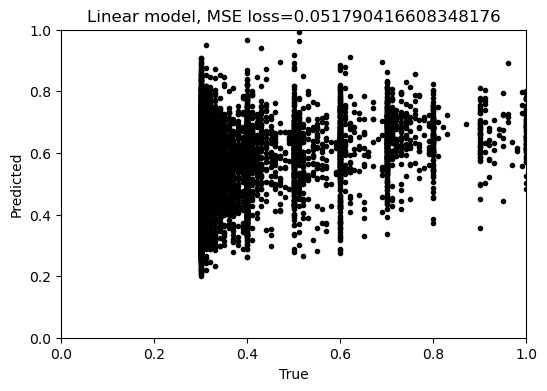

In [237]:
plot(out[0]['test/loss'], torch.tensor(ypreds0).numpy(), testdf['Y'], 'linear_final_weight_1','Linear model')

In [238]:
accurate = 0
for j,pred in enumerate(torch.tensor(ypreds0).numpy()):
    if np.abs(testdf.loc[j,'Y'] - pred) < 0.1:
        accurate += 1
print(f'Accuracy considering prediction to be within 0.1 is {np.round(100*accurate/len(testdf),2)}%')

Accuracy considering prediction to be within 0.1 is 20.23%


## Simple CNN model, Regression

In [213]:
def conv_block(inp_size, out_size, kernel_size):
    block = nn.Sequential(
            nn.Conv1d(inp_size, out_size, kernel_size),
            nn.BatchNorm1d(out_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
    )
    return block

class GDARegression(pl.LightningModule):
    def __init__(self, lr=1e-3, num_workers=4):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        
        self.convg1 = conv_block(1,16,5)
        self.convg2 = conv_block(16,32,5)
        self.convg3 = conv_block(32,16,3)
        self.lng1 = nn.Linear(16*157,256)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.dropout5 = nn.Dropout(0.5)
        self.dropout8 = nn.Dropout(0.8)
        self.lng2 = nn.Linear(256,64)
        self.lng3 = nn.Linear(64,16)
        
        self.convd1 = conv_block(1,8,5)
        self.convd2 = conv_block(8,16,3)
        self.lnd1 = nn.Linear(16*3,32)
        self.lnd2 = nn.Linear(32,16)
        
        self.lnc = nn.Linear(32,1)
        
    def forward(self, gene, disease):
        g = self.convg1(gene)
        g = self.convg2(g)
        g = self.convg3(g)
        g = g.reshape(g.shape[0],-1)
        g = self.lng1(g)
        g = self.relu(g)
        g = self.lng2(g)
        g = self.relu(g)
        g = self.lng3(g)
        g = self.relu(g)
#         print(g.shape)
        
        d = self.convd1(disease)
        d = self.convd2(d)
        d = d.reshape(d.shape[0],-1)
        d = self.lnd1(d)
        d = self.relu(d)
        d = self.lnd2(d)
        d = self.relu(d)
        
#         print(d.shape)
        x = torch.cat((g,d),dim=1)
        x = self.relu(x)
        x = self.lnc(x)
#         print(x.shape)
        return x
    
    def training_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
#         mse = nn.MSELoss()
#         mse_loss = mse(y_pred,y)
#         l1 = nn.L1Loss()
#         l1_loss = l1(y_pred,y)
        
        mse = nn.MSELoss(reduction='none')
        mse_loss = (mse(y_pred,y)*weight).sum()
        l1 = nn.L1Loss(reduction='none')
        l1_loss = (l1(y_pred,y)*weight).sum()

        self.log('train/loss',mse_loss,on_epoch=True)
        self.log('train/lossl1',l1_loss,on_epoch=True)
        return mse_loss
    
    def validation_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
#         mse = nn.MSELoss()
#         mse_loss_val = mse(y_pred,y)
#         l1 = nn.L1Loss()
#         l1_loss_val = l1(y_pred,y)
        
        mse = nn.MSELoss(reduction='none')
        mse_loss_val = (mse(y_pred,y)*weight).sum()        
        l1 = nn.L1Loss(reduction='none')
        l1_loss_val = (l1(y_pred,y)*weight).sum()
        
        self.log('valid/loss',mse_loss_val,on_epoch=True)
        self.log('valid/lossl1',l1_loss_val,on_epoch=True)
        
        return mse_loss_val
    
    def test_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
#         mse = nn.MSELoss()
#         mse_loss_test = mse(y_pred,y)
#         l1 = nn.L1Loss()
#         l1_loss_test = l1(y_pred,y)
        
        mse = nn.MSELoss(reduction='none')
        mse_loss_test = (mse(y_pred,y)*weight).sum()        
        l1 = nn.L1Loss(reduction='none')
        l1_loss_test = (l1(y_pred,y)*weight).sum()
        
        self.log('test/loss',mse_loss_test,on_epoch=True)
        self.log('test/lossl1',l1_loss_test,on_epoch=True)
        
        return mse_loss_test

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)
    
    def predict_step(self,batch,batch_idx):
        gene, disease, y, weight = batch
        return self(gene,disease)

In [239]:
trainset0 = GDPair(traindf,datatype='train',load_from_save=True)
valset0 = GDPair(valdf,datatype='val',load_from_save=True)
testset0 = GDPair(testdf,datatype='test',load_from_save=True)

trainloader0 = DataLoader(trainset0, batch_size=64, shuffle=True)
valloader0 = DataLoader(valset0, batch_size=64)
testloader0 = DataLoader(testset0, batch_size=64)
predictloader0 = DataLoader(testset0, batch_size=1)

In [240]:
logger = TensorBoardLogger("logs",name="GDA_CNN")
earlystop = EarlyStopping(monitor="valid/loss", patience=7, verbose=True)
model = GDARegression(lr=1e-3)
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=logger, max_epochs=30, callbacks=earlystop)
trainer.fit(model, train_dataloaders=trainloader0,val_dataloaders=valloader0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type       | Params
-----------------------------------------
0  | convg1   | Sequential | 128   
1  | convg2   | Sequential | 2.7 K 
2  | convg3   | Sequential | 1.6 K 
3  | lng1     | Linear     | 643 K 
4  | relu     | ReLU       | 0     
5  | dropout2 | Dropout    | 0     
6  | dropout5 | Dropout    | 0     
7  | dropout8 | Dropout    | 0     
8  | lng2     | Linear     | 16.4 K
9  | lng3     | Linear     | 1.0 K 
10 | convd1   | Sequential | 64    
11 | convd2   | Sequential | 432   
12 | lnd1     | Linear     | 1.6 K 
13 | lnd2     | Linear     | 528   
14 | lnc      | Linear     | 33    
-----------------------------------------
667 K     Trainable params
0         Non-trainable params
667 K     Total params
2.671     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved. New best score: 2.727


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.005 >= min_delta = 0.0. New best score: 2.722


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.030 >= min_delta = 0.0. New best score: 2.692


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.010 >= min_delta = 0.0. New best score: 2.682


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.073 >= min_delta = 0.0. New best score: 2.608


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.025 >= min_delta = 0.0. New best score: 2.584


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.096 >= min_delta = 0.0. New best score: 2.488


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 2.487


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid/loss did not improve in the last 7 records. Best score: 2.487. Signaling Trainer to stop.


In [241]:
out = trainer.test(model, dataloaders=testloader0)
ypreds = trainer.predict(model,dataloaders=predictloader0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss            2.673361553372825
       test/lossl1           9.415531071363755
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 574it [00:00, ?it/s]

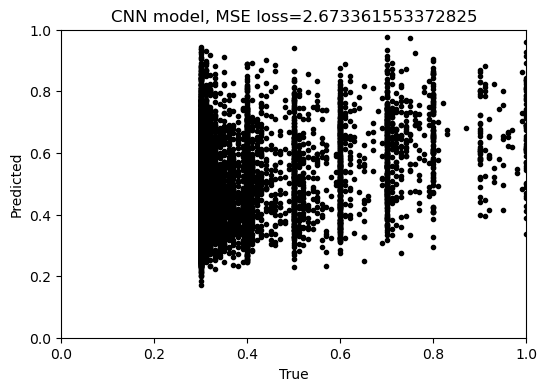

In [242]:
plot(out[0]['test/loss'], torch.tensor(ypreds).numpy(), testdf['Y'], 'cnn_final_weight_1', 'CNN model')

In [243]:
accurate = 0
for j,pred in enumerate(torch.tensor(ypreds).numpy()):
    if np.abs(testdf.loc[j,'Y'] - pred) < 0.1:
        accurate += 1
print(f'Accuracy considering prediction to be within 0.1 is {accurate/len(testdf)}')

Accuracy considering prediction to be within 0.1 is 0.40848022868032396


### As data labels are highly imbalanced, trying label distribution smoothening

In [219]:
labels, counts = np.unique(trainset1.data['Y'],return_counts=True)

In [244]:
from sklearn.neighbors import KernelDensity
kde0 = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(np.array(trainset1.data['Y']).reshape(-1,1))
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(trainset1.data['Y']).reshape(-1,1))

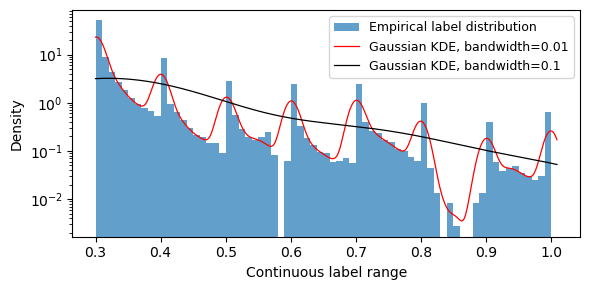

In [256]:
logdens0 = kde0.score_samples(np.arange(0.3,1.01,0.001).reshape(-1,1))
logdens = kde.score_samples(np.arange(0.3,1.01,0.001).reshape(-1,1))

plt.figure(figsize=(6,3))
_ = plt.hist(trainset1.data['Y'],bins=70,density=True,alpha=0.7,label='Empirical label distribution')
plt.plot(np.arange(0.3,1.01,0.001),np.exp(logdens0),color='red',lw=0.9,label='Gaussian KDE, bandwidth=0.01')
plt.plot(np.arange(0.3,1.01,0.001),np.exp(logdens),color='black',lw=0.9,label='Gaussian KDE, bandwidth=0.1')
plt.yscale('log')
plt.xlabel('Continuous label range')
plt.ylabel('Density')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('kde.png',dpi=200)

Adding above as sample weights to dataset class

**Notes** <br>
lr=1e-3 is better than lr=1e-2 <br>
batch size of 64 did better than batch size of 32 <br>
batch normalization helped <br>
dropout made things worse <br>
batchnorm after linear didn't improve things <br>
one less linear layer marginal improvement in loss curve <br>
one more linear layer about the same <br>
This data is terrible for training, I don't know how 'Y' is being calculated and it is weirdly centered around the 10ths<br>

## CNN but Classifier

In [76]:
def conv_block(inp_size, out_size, kernel_size):
    block = nn.Sequential(
            nn.Conv1d(inp_size, out_size, kernel_size),
            nn.BatchNorm1d(out_size),
            nn.ReLU(),
            nn.MaxPool1d(2)
    )
    return block

class GDAClassification(pl.LightningModule):
    def __init__(self, lr=1e-3, num_workers=4):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        
        self.convg1 = conv_block(1,16,5)
        self.convg2 = conv_block(16,32,5)
        self.convg3 = conv_block(32,16,3)
        self.lng1 = nn.Linear(16*157,256)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.dropout5 = nn.Dropout(0.5)
        self.dropout8 = nn.Dropout(0.8)
        self.lng2 = nn.Linear(256,64)
        self.lng3 = nn.Linear(64,16)
        
        self.convd1 = conv_block(1,8,5)
        self.convd2 = conv_block(8,16,3)
        self.lnd1 = nn.Linear(16*3,32)
        self.lnd2 = nn.Linear(32,16)
        
        self.lnc = nn.Linear(32,7)
        self.accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=7)
        
    def forward(self, gene, disease):
        g = self.convg1(gene)
        g = self.convg2(g)
        g = self.convg3(g)
        g = g.reshape(g.shape[0],-1)
        g = self.lng1(g)
        g = self.relu(g)
        g = self.lng2(g)
        g = self.relu(g)
        g = self.lng3(g)
        g = self.relu(g)
#         print(g.shape)
        
        d = self.convd1(disease)
        d = self.convd2(d)
        d = d.reshape(d.shape[0],-1)
        d = self.lnd1(d)
        d = self.relu(d)
        d = self.lnd2(d)
        d = self.relu(d)
        
#         print(d.shape)
        x = torch.cat((g,d),dim=1)
        x = self.relu(x)
        x = self.lnc(x)
#         print(x.shape)
        return  x
    
    def training_step(self,batch,batch_idx):
        gene, disease, y = batch
        y_pred = self(gene, disease)
        
        criterion = nn.CrossEntropyLoss()
        loss = criterion(y_pred,y)
        self.log('train/loss',loss,on_epoch=True)
        
        preds = torch.argmax(nn.functional.log_softmax(self(gene, disease)), dim=1)
        acc = self.accuracy(preds, y)
        self.log('train/accuracy',acc,on_epoch=True)
        
        return loss
    
    def validation_step(self,batch,batch_idx):
        gene, disease, y = batch
        y_pred = self(gene, disease)
        
        criterion = nn.CrossEntropyLoss()
        val_loss = criterion(y_pred,y)
        self.log('valid/loss',val_loss,on_epoch=True)
        
        preds = torch.argmax(nn.functional.log_softmax(self(gene, disease)), dim=1)
        val_acc = self.accuracy(preds, y)
        self.log('valid/accuracy',val_acc,on_epoch=True)

        return val_loss
    
    def test_step(self,batch,batch_idx):
        gene, disease, y = batch
        y_pred = self(gene, disease)
        
        criterion = nn.CrossEntropyLoss()
        test_loss = criterion(y_pred,y)
        self.log('test/loss',test_loss,on_epoch=True)
        
        preds = torch.argmax(nn.functional.log_softmax(self(gene, disease)), dim=1)
        test_acc = self.accuracy(preds, y)
        self.log('test/accuracy',test_acc,on_epoch=True)
        return test_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)
    
    def predict_step(self,batch,batch_idx):
        gene, disease, y = batch
        preds = torch.argmax(nn.functional.log_softmax(self(gene, disease)), dim=1)
        return preds

In [67]:
trainset1 = GDPair(traindf,datatype='train',load_from_save=True,mode='cat')
valset1 = GDPair(valdf,datatype='val',load_from_save=True,mode='cat')
testset1 = GDPair(testdf,datatype='test',load_from_save=True,mode='cat')

trainloader = DataLoader(trainset1, batch_size=64, shuffle=True)
valloader = DataLoader(valset1, batch_size=64)
testloader = DataLoader(testset1, batch_size=64)
predictloader = DataLoader(testset1, batch_size=1)

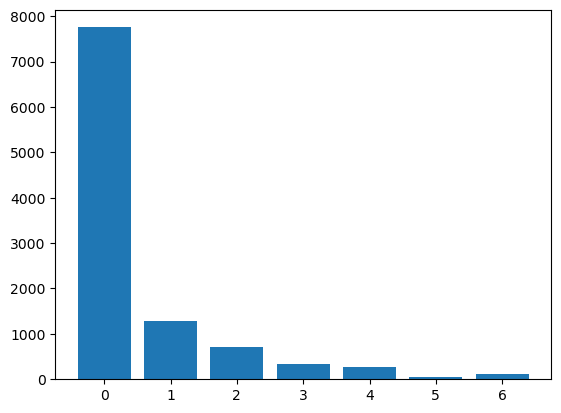

In [87]:
labels, counts = np.unique(testset1.labels,return_counts=True)
_ = plt.bar(labels,counts)

In [88]:
logger = TensorBoardLogger("logs",name="GDA_CNN_cat")
earlystop = EarlyStopping(monitor="valid/loss", patience=7, verbose=True)
model = GDAClassification(lr=1e-3)
trainer = pl.Trainer(accelerator="gpu", devices=1, logger=logger, max_epochs=50, callbacks=earlystop)
trainer.fit(model, train_dataloaders=trainloader,val_dataloaders=valloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type               | Params
-------------------------------------------------
0  | convg1   | Sequential         | 128   
1  | convg2   | Sequential         | 2.7 K 
2  | convg3   | Sequential         | 1.6 K 
3  | lng1     | Linear             | 643 K 
4  | relu     | ReLU               | 0     
5  | dropout2 | Dropout            | 0     
6  | dropout5 | Dropout            | 0     
7  | dropout8 | Dropout            | 0     
8  | lng2     | Linear             | 16.4 K
9  | lng3     | Linear             | 1.0 K 
10 | convd1   | Sequential         | 64    
11 | convd2   | Sequential         | 432   
12 | lnd1     | Linear             | 1.6 K 
13 | lnd2     | Linear             | 528   
14 | lnc      | Linear             | 231   
15 | accuracy | MulticlassAccuracy | 0     
-------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved. New best score: 0.939


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.016 >= min_delta = 0.0. New best score: 0.923


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.915


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.913


Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.901


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.892


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric valid/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.890


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric valid/loss did not improve in the last 7 records. Best score: 0.890. Signaling Trainer to stop.


In [89]:
out = trainer.test(model, dataloaders=testloader)
ypreds = trainer.predict(model,dataloaders=predictloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy          0.731681764125824
        test/loss            0.876594603061676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 574it [00:00, ?it/s]

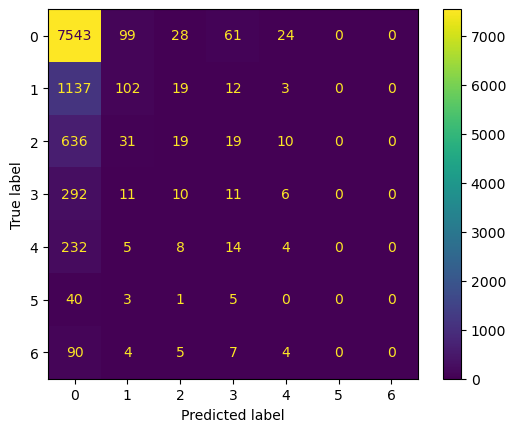

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(testset1.labels, torch.tensor(ypreds))
ConfusionMatrixDisplay(cm).plot()

## RNN-CNN (incomplete)

In [ ]:
emb = ESM1bEmbedder()

In [ ]:
gn = traindf.loc[100,'Gene']

In [ ]:
gnv = []
for i in range(len(gn)//1022 + 1):
    gnv = gnv + emb.embed(gn[i*1022:min(len(gn),(i+1)*1022)]).tolist()

In [ ]:
class GDPair(torch.utils.data.Dataset):
    def __init__(self,data,load_from_save=False,datatype='train'):
        if not load_from_save:
            self.data = data # data is pandas dataframe of samples
            self.tokenize_diseases()
            # Train doc2vec embeddings for disease if model doesn't exist already
            if glob2.glob('disease_doc2vec') == []:
                self.embed_model_disease = self.train_doc2vec_embeddings(which='disease_tokens',size=20)
            else:
                print('Found disease doc2vec model')
                self.embed_model_disease = Doc2Vec.load('disease_doc2vec')

            self.embed_model_gene = ESM1bEmbedder()

            self.genes = []
            self.diseases = []
            for i in range(len(data)):
                row = data.loc[i]
                self.genes += [torch.tensor(self.process_gene_esm(row['Gene'])).unsqueeze(0)]
                self.diseases += [torch.tensor(self.process_disease(row['disease_tokens'])).unsqueeze(0)]
            torch.save(self.genes, f'gene_vector_{datatype}.pt')
            torch.save(self.diseases, f'disease_vector_{datatype}.pt')
            
        else:
            self.data = data
            self.genes = torch.load(f'gene_vector_{datatype}.pt')
            self.diseases = torch.load(f'disease_vector_{datatype}.pt')

    
    def tokenize_diseases(self):
        removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'SYM']
        nlp = en_core_web_md.load()
        tokens = []
        for disease in nlp.pipe(self.data['Disease']):
            tokens.append([token.lemma_ for token in disease if token.pos_ not in removal])
        self.data['disease_tokens']  = tokens
        
    def train_doc2vec_embeddings(self,which='disease_tokens',size=20):
        tokens = self.data[which]
        dictionary = Dictionary(self.data[which])
        documents = [TaggedDocument(doc,dictionary.doc2idx(doc)) for doc in tokens]
        model = Doc2Vec(documents,vector_size=size)
        print('Finished Doc2Vec embedding for ',which)
        model.save(f'{which.split("_")[0]}_doc2vec')
        return model
        
    def process_disease(self,disease_token):
        return self.embed_model_disease.infer_vector(disease_token)
    
    def process_gene_esm(self,gene):
        embedder = self.embed_model_gene
        gnv = []
        for i in range(len(gene)//1022 + 1):
            gnv = gnv + list(emb.embed(gene[i*1022:min(len(gene),(i+1)*1022)]))
        return gnv
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.genes[i],self.diseases[i],self.data.loc[i,'Y']


In [ ]:
class GDARNN(pl.LightningModule):
    def __init__(self, lr=1e-3, num_workers=4, batch_size=32):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.rmse = Evaluator(name='RMSE')
        self.r2 = Evaluator(name='R2')
        self.spm = Evaluator(name='Spearman')
        self.criterions = [self.rmse, self.r2, self.spm]
        

        
    def forward(self, gene, disease):

        return self.lnc2(x)
    
    def training_step(self,batch,batch_idx):
        gene, disease, y = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
        mse = nn.MSELoss()
        mse_loss = mse(y_pred,y)
        self.log('train/loss',mse_loss,on_epoch=True)
        
        l1 = nn.L1Loss()
        l1_loss = l1(y_pred,y)
        self.log('train/lossl1',l1_loss,on_epoch=True)

        losses = [criterion(y.cpu(), y_pred.cpu().detach().numpy()) for criterion in self.criterions]
        self.log('train/loss_rmse',losses[0],on_epoch=True)
        self.log('train/loss_r2',losses[1],on_epoch=True)
        self.log('train/loss_spm',losses[2],on_epoch=True)
        return l1_loss
    
    def validation_step(self,batch,batch_idx):
        gene, disease, y = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
        mse = nn.MSELoss()
        mse_loss = mse(y_pred,y)
        self.log('valid/loss',mse_loss,on_epoch=True)
        
        l1 = nn.L1Loss()
        l1_loss = l1(y_pred,y)
        self.log('valid/lossl1',l1_loss,on_epoch=True)
        
        losses = [criterion(y.cpu(), y_pred.cpu().detach().numpy()) for criterion in self.criterions]
        self.log('valid/loss_rmse',losses[0],on_epoch=True)
        self.log('valid/loss_r2',losses[1],on_epoch=True)
        self.log('valid/loss_spm',losses[2],on_epoch=True)
        return l1_loss
    
    def test_step(self,batch,batch_idx):
        gene, disease, y = batch
        y_pred = torch.flatten(self(gene, disease)).double()
        
        mse = nn.MSELoss()
        mse_loss = mse(y_pred,y)
        self.log('test/loss',mse_loss,on_epoch=True)
        
        l1 = nn.L1Loss()
        l1_loss = l1(y_pred,y)
        self.log('test/lossl1',l1_loss,on_epoch=True)
        
        losses = [criterion(y.cpu(), y_pred.cpu().detach().numpy()) for criterion in self.criterions]
        self.log('test/loss_rmse',losses[0],on_epoch=True)
        self.log('test/loss_r2',losses[1],on_epoch=True)
        self.log('test/loss_spm',losses[2],on_epoch=True)
        return l1_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)
    
    def predict_step(self,batch,batch_idx):
        gene, disease, y = batch
        return self(gene,disease)
    